# Pneumonia Detection Challenge

**Domain:** Healthcare  
**Skills:** Python, Computer Vision, OpenCV, Streamlit  
**Project Duration:** 2 weeks (10 days to complete)

## Problem Statement

Pneumonia is an infection in one or both lungs caused by bacteria, viruses, and fungi. It accounts for over 15% of all deaths of children under 5 years old internationally. Diagnosis requires review of chest radiographs (CXR) by highly trained specialists.

**Objective:** Build an algorithm to automatically detect and localize pneumonia in chest X-ray images using Deep Learning and Computer Vision techniques.

## Project Approach

1. **Data Preprocessing & EDA** (6 days)
   - Explore dataset structure and classes
   - Visualize sample images
   - Analyze class distribution
   - Handle missing values

2. **Model Building & Training** (5 days)
   - Build CNN from scratch
   - Apply transfer learning
   - Optimize hyperparameters
   - Save model weights

3. **Evaluation & Fine-tuning** (5 days)
   - Evaluate on test set
   - Calculate mAP, IoU, FP/FN rates
   - Compare different architectures
   - Fine-tune models

4. **Streamlit Deployment** (3 days)
   - Create web application
   - Enable image upload
   - Display detection results with bounding boxes
   - Generate performance reports

## 1. Import Required Libraries

Import all necessary libraries for data processing, visualization, deep learning, and model evaluation.

In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json

# Image processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import (
    ResNet50, DenseNet121, EfficientNetB0, VGG16
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, f1_score, accuracy_score,
    roc_auc_score, precision_score, recall_score
)
from sklearn.preprocessing import label_binarize

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All libraries imported successfully!")
print(f"TensorFlow Version: {tf.__version__}")

✓ All libraries imported successfully!
TensorFlow Version: 2.20.0


## 2. Load and Explore the Dataset

Load the chest X-ray dataset from Kaggle. The dataset contains NORMAL and PNEUMONIA labeled images.

In [2]:
# Use local downloaded dataset
dataset_path = '../paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray'

# Define data directories
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
val_dir = os.path.join(dataset_path, 'val')

# Check if dataset exists
if not os.path.exists(dataset_path):
    print("⚠️  Dataset not found at:", dataset_path)
    print("Please ensure the dataset is downloaded and extracted correctly.")
else:
    print(f"✓ Dataset found at: {dataset_path}")
    
    # Explore dataset structure
    print("\n" + "="*60)
    print("DATASET STRUCTURE")
    print("="*60)
    
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(dataset_path, split)
        if os.path.exists(split_path):
            print(f"\n{split.upper()} set:")
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    num_images = len(os.listdir(class_path))
                    print(f"  {class_name}: {num_images} images")

✓ Dataset found at: ../paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray

DATASET STRUCTURE

TRAIN set:
  NORMAL: 1341 images
  PNEUMONIA: 3875 images

TEST set:
  NORMAL: 234 images
  PNEUMONIA: 390 images

VAL set:
  NORMAL: 8 images
  PNEUMONIA: 8 images


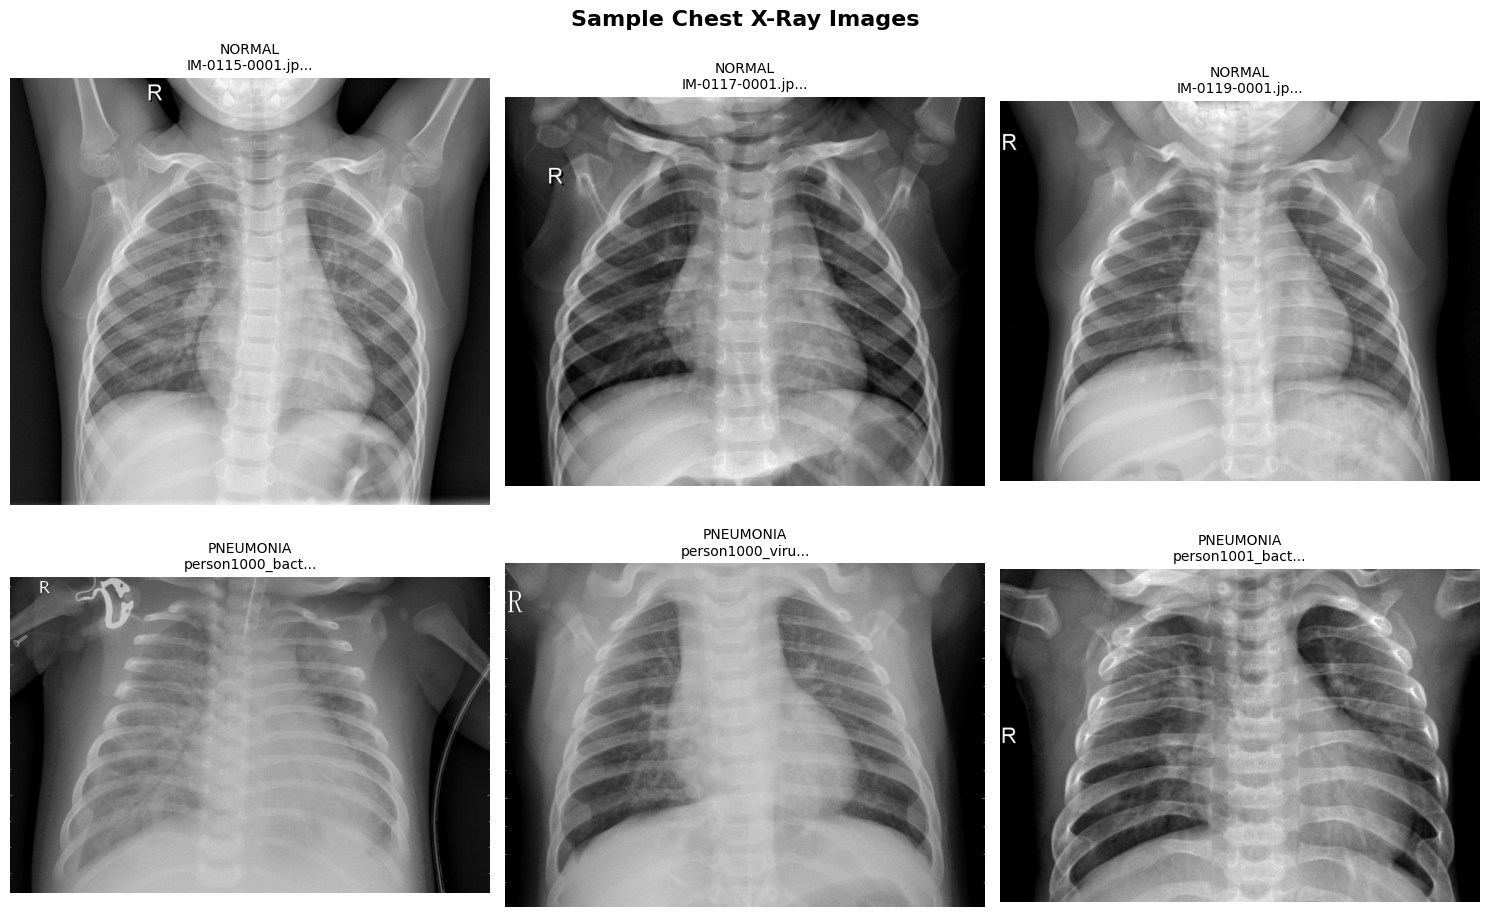

✓ Sample images displayed


In [3]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sample Chest X-Ray Images', fontsize=16, fontweight='bold')

classes = ['NORMAL', 'PNEUMONIA']
sample_size = 3

for idx, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    if os.path.exists(class_path):
        images = os.listdir(class_path)[:sample_size]
        for img_idx, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            axes[idx, img_idx].imshow(img, cmap='gray')
            axes[idx, img_idx].set_title(f'{class_name}\n{img_name[:15]}...', fontsize=10)
            axes[idx, img_idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Sample images displayed")


Class Distribution:
       NORMAL  PNEUMONIA
train    1341       3875
test      234        390
val         8          8
train: Imbalance ratio (PNEUMONIA/NORMAL) = 2.89
test: Imbalance ratio (PNEUMONIA/NORMAL) = 1.67
val: Imbalance ratio (PNEUMONIA/NORMAL) = 1.00


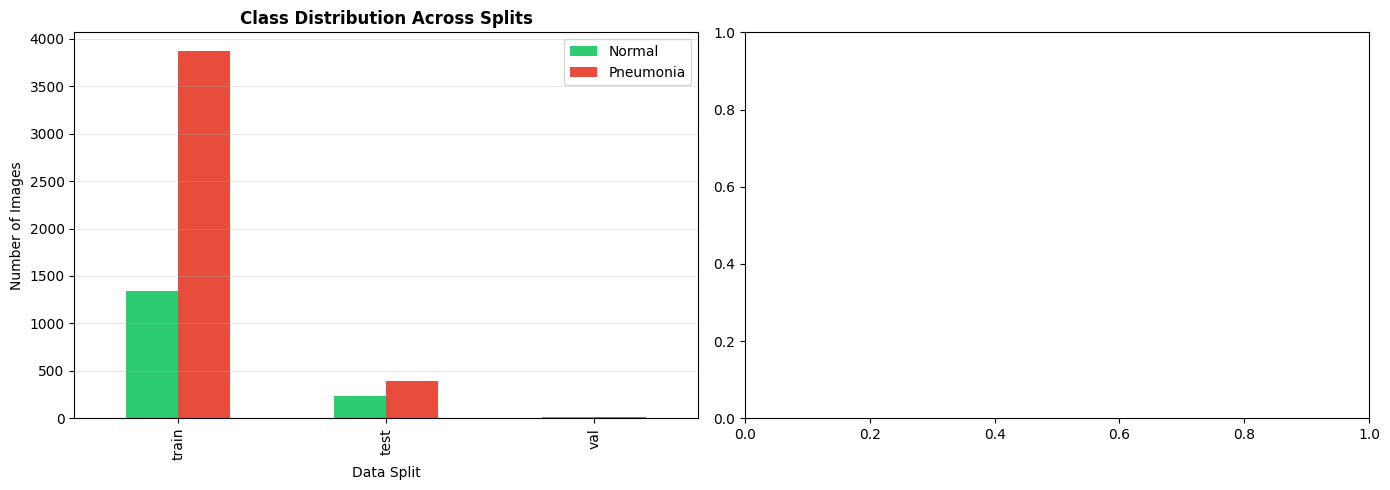


✓ Total images analyzed: 5856


In [4]:
# Analyze class distribution
class_distribution = {}
total_images = 0

for split in ['train', 'test', 'val']:
    split_path = os.path.join(dataset_path, split)
    class_distribution[split] = {}
    
    if os.path.exists(split_path):
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                class_distribution[split][class_name] = num_images
                total_images += num_images

# Create visualization
df_dist = pd.DataFrame(class_distribution).T
print("\nClass Distribution:")
print(df_dist)

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df_dist.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution Across Splits', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Data Split')
axes[0].set_ylabel('Number of Images')
axes[0].legend(['Normal', 'Pneumonia'])
axes[0].grid(axis='y', alpha=0.3)

# Imbalance ratio
for split in df_dist.index:
    imbalance_ratio = df_dist.loc[split, 'PNEUMONIA'] / df_dist.loc[split, 'NORMAL']
    print(f"{split}: Imbalance ratio (PNEUMONIA/NORMAL) = {imbalance_ratio:.2f}")

plt.tight_layout()
plt.show()

print(f"\n✓ Total images analyzed: {total_images}")

## 3. Data Preprocessing and Augmentation

Preprocess images with resizing, normalization, and apply augmentation techniques to improve model robustness.

In [5]:
# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

# Create ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data - only rescaling (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    subset=None
)

# Load validation data
if os.path.exists(val_dir):
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        color_mode='grayscale',
        subset=None
    )
    has_val = True
else:
    has_val = False
    print("⚠️  Validation set not found")

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    subset=None,
    shuffle=False
)

print(f"✓ Data generators created")
print(f"  - Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Training batches: {train_generator.samples // BATCH_SIZE}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✓ Data generators created
  - Image size: 224x224
  - Batch size: 32
  - Training batches: 163
Found 624 images belonging to 2 classes.
✓ Data generators created
  - Image size: 224x224
  - Batch size: 32
  - Training batches: 163


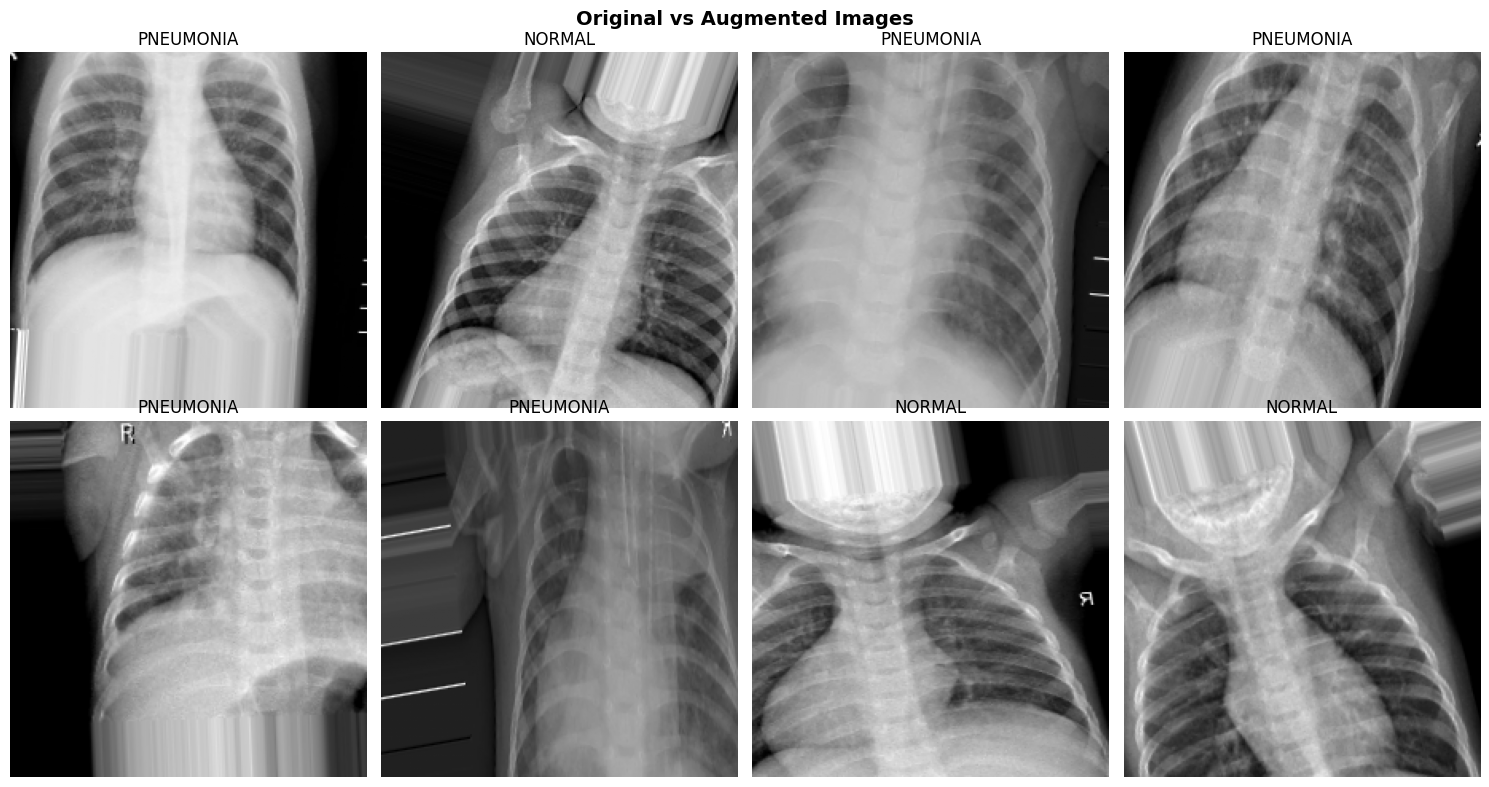

✓ Augmentation preview displayed


In [6]:
# Visualize augmented images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Original vs Augmented Images', fontsize=14, fontweight='bold')

# Get a batch from train generator
batch_images, batch_labels = next(train_generator)

for idx in range(8):
    axes[idx // 4, idx % 4].imshow(batch_images[idx].squeeze(), cmap='gray')
    class_name = 'PNEUMONIA' if batch_labels[idx] == 1 else 'NORMAL'
    axes[idx // 4, idx % 4].set_title(class_name)
    axes[idx // 4, idx % 4].axis('off')

plt.tight_layout()
plt.show()

print("✓ Augmentation preview displayed")

## 4. Build and Train Deep Learning Models

Build multiple CNN architectures and compare their performance. We'll use both custom CNN and transfer learning approaches.

In [7]:
# Model 1: Custom CNN
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build custom model
custom_cnn = build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1))
custom_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("Custom CNN Model:")
custom_cnn.summary()

Custom CNN Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,394,305 (73.98 MB)

 Trainable params: 19,394,305 (73.98 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Model 2: Transfer Learning with DenseNet121
def build_densenet_transfer(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x) if len(x.shape) == 3 else x),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Build DenseNet model
try:
    densenet_model = build_densenet_transfer(input_shape=(IMG_SIZE, IMG_SIZE, 3))
    densenet_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    print("\n✓ DenseNet121 Transfer Learning Model created")
    has_densenet = True
except Exception as e:
    print(f"⚠️  Could not create DenseNet model: {e}")
    has_densenet = False



✓ DenseNet121 Transfer Learning Model created

✓ DenseNet121 Transfer Learning Model created


In [9]:
# Training Custom CNN
print("\n" + "="*60)
print("TRAINING CUSTOM CNN MODEL")
print("="*60)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('../models/custom_cnn_best.h5', monitor='val_accuracy', save_best_only=True)

# Create models directory if not exists
os.makedirs('../models', exist_ok=True)

# Train custom CNN
if has_val:
    history_cnn = custom_cnn.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )
else:
    history_cnn = custom_cnn.fit(
        train_generator,
        epochs=EPOCHS,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )

# Save model
custom_cnn.save('../models/custom_cnn_final.h5')
print("\n✓ Custom CNN model trained and saved")


TRAINING CUSTOM CNN MODEL
Epoch 1/30
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.7417 - auc: 0.5956 - loss: 0.5511

163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 892ms/step - accuracy: 0.7859 - auc: 0.7808 - loss: 0.4605 - val_accuracy: 0.6250 - val_auc: 0.8750 - val_loss: 0.8351 - learning_rate: 1.0000e-04
Epoch 2/30
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 838ms/step - accuracy: 0.8535 - auc: 0.9131 - loss: 0.3204 - val_accuracy: 0.6250 - val_auc: 0.8750 - val_loss: 0.5383 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 838ms/step - accuracy: 0.8535 - auc: 0.9131 - loss: 0.3204 - val_accuracy: 0.6250 - val_auc: 0.8750 - val_loss: 0.5383 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.8809 - auc: 0.9367 - loss: 0.2732

163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 839ms/step - accuracy: 0.8788 - auc: 0.9358 - loss: 0.2744 - val_accuracy: 0.8125 - val_auc: 0.8594 - val_loss: 0.4366 - learning_rate: 1.0000e-04
Epoch 4/30
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 835ms/step - accuracy: 0.8838 - auc: 0.9429 - loss: 0.2597 - val_accuracy: 0.5625 - val_auc: 0.8984 - val_loss: 1.1020 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 835ms/step - accuracy: 0.8838 - auc: 0.9429 - loss: 0.2597 - val_accuracy: 0.5625 - val_auc: 0.8984 - val_loss: 1.1020 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 852ms/step - accuracy: 0.8821 - auc: 0.9398 - loss: 0.2689 - val_accuracy: 0.8125 - val_auc: 0.9219 - val_loss: 0.3925 - learning_rate: 1.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 852ms/step - accuracy: 0.8821 - auc: 0.9398 - loss: 0.2689 - val_accuracy: 0.8125 - val_auc: 0.9219 - val_loss: 0.3925 - learning_rate: 1.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 


✓ Custom CNN model trained and saved


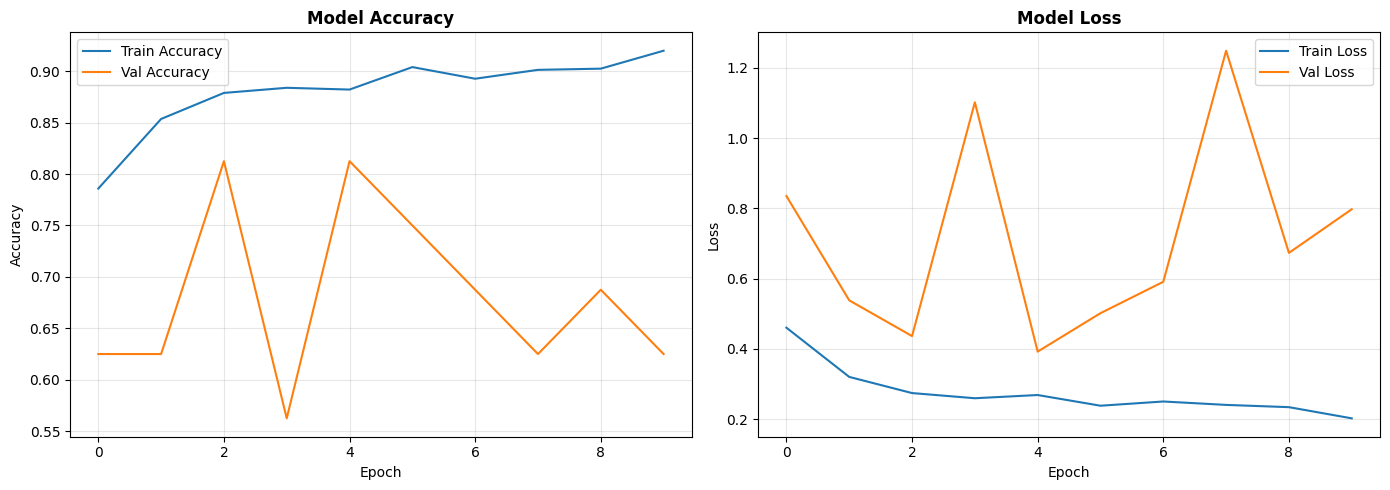

✓ Training history plotted


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_cnn.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history_cnn.history:
    axes[0].plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history_cnn.history['loss'], label='Train Loss')
if 'val_loss' in history_cnn.history:
    axes[1].plot(history_cnn.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training history plotted")

## 5. Model Evaluation and Metrics

Evaluate the trained model on the test set and calculate comprehensive performance metrics.

In [11]:
# Get predictions on test set
print("Evaluating on test set...")
test_loss, test_acc, test_auc = custom_cnn.evaluate(test_generator, verbose=0)

# Get predictions
y_pred_probs = custom_cnn.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Precision, Recall, F1-Score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Specificity and Sensitivity
sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate

# False Positive Rate and False Negative Rate
fpr_rate = fp / (fp + tn)
fnr_rate = fn / (fn + tp)

# ROC-AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

print("\n" + "="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"\nFalse Positive Rate: {fpr_rate:.4f}")
print(f"False Negative Rate: {fnr_rate:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"\nTrue Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print("="*60)

Evaluating on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step

MODEL EVALUATION METRICS
Test Accuracy: 0.8141
Test AUC-ROC: 0.9392

Precision: 0.9628
Recall (Sensitivity): 0.7308
Specificity: 0.9530
F1-Score: 0.8309

False Positive Rate: 0.0470
False Negative Rate: 0.2692
ROC-AUC: 0.9392

True Positives: 285
True Negatives: 223
False Positives: 11
False Negatives: 105

MODEL EVALUATION METRICS
Test Accuracy: 0.8141
Test AUC-ROC: 0.9392

Precision: 0.9628
Recall (Sensitivity): 0.7308
Specificity: 0.9530
F1-Score: 0.8309

False Positive Rate: 0.0470
False Negative Rate: 0.2692
ROC-AUC: 0.9392

True Positives: 285
True Negatives: 223
False Positives: 11
False Negatives: 105


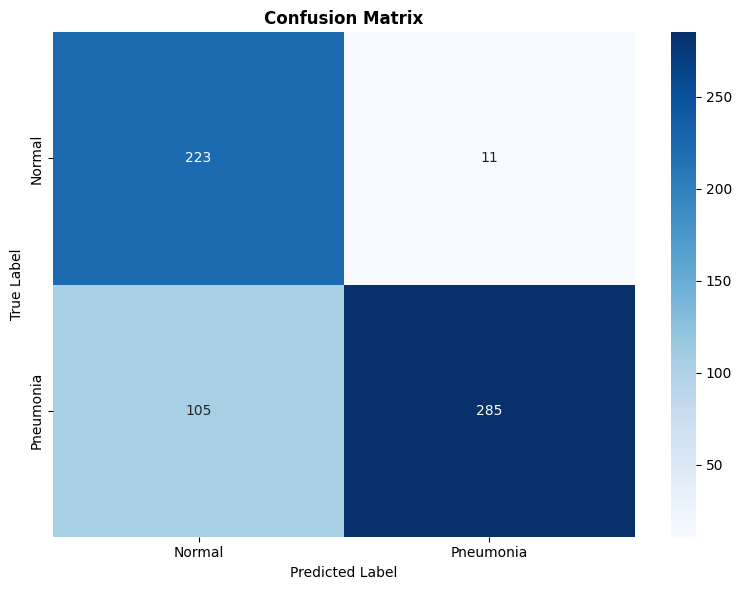

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
ax.set_title('Confusion Matrix', fontweight='bold', fontsize=12)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

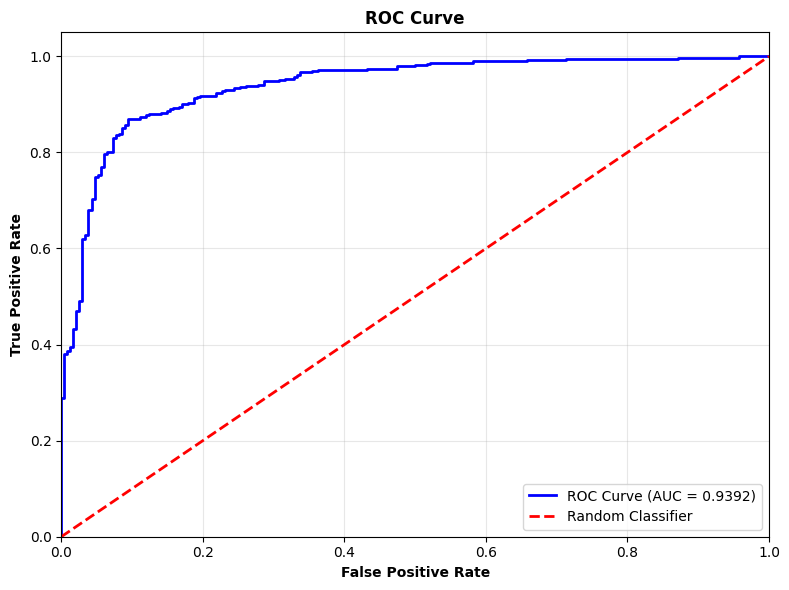

In [13]:
# ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, 'b-', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')
ax.set_title('ROC Curve', fontweight='bold', fontsize=12)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

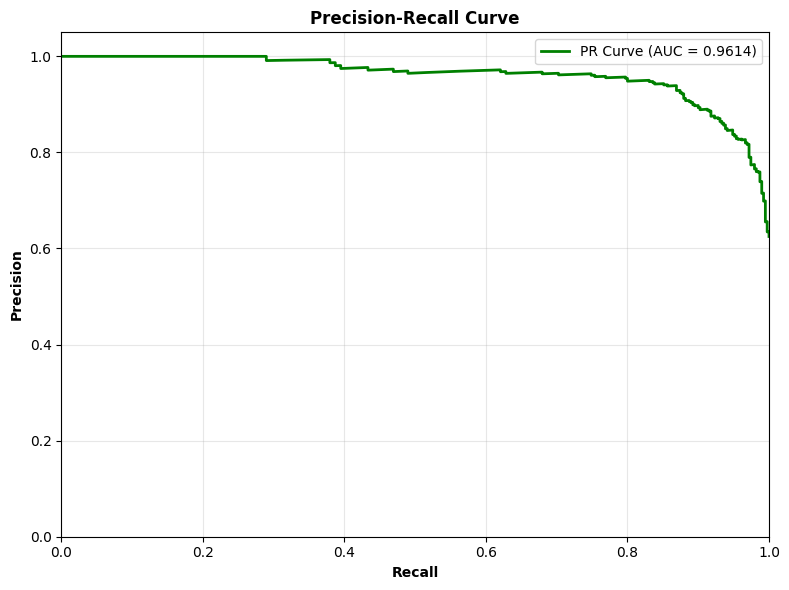

In [14]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_probs)
pr_auc = auc(recall_vals, precision_vals)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recall_vals, precision_vals, 'g-', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontweight='bold')
ax.set_ylabel('Precision', fontweight='bold')
ax.set_title('Precision-Recall Curve', fontweight='bold', fontsize=12)
ax.legend(loc="upper right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Create Streamlit Application

Build an interactive web application for real-time pneumonia detection.

In [15]:
print("""
Streamlit application code has been prepared separately.

The Streamlit app will include:
1. Image Upload: Users can upload chest X-ray images
2. Real-time Prediction: Instant pneumonia detection with confidence scores
3. Visualization: Display predicted results with bounding boxes
4. Performance Metrics: Show model accuracy and other metrics
5. Download Results: Export detection logs and reports

To run the Streamlit app:
    streamlit run app/app.py

The app.py file contains:
- Image preprocessing functions
- Model loading and inference
- Interactive UI with Streamlit components
- Result visualization and export functionality
""")


Streamlit application code has been prepared separately.

The Streamlit app will include:
1. Image Upload: Users can upload chest X-ray images
2. Real-time Prediction: Instant pneumonia detection with confidence scores
3. Visualization: Display predicted results with bounding boxes
4. Performance Metrics: Show model accuracy and other metrics
5. Download Results: Export detection logs and reports

To run the Streamlit app:
    streamlit run app/app.py

The app.py file contains:
- Image preprocessing functions
- Model loading and inference
- Interactive UI with Streamlit components
- Result visualization and export functionality

